Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Fit the P3M limiter from existing simulation data

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH + "results/"
output_path = OUTPUT_PATH

In [3]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile, join
from pathlib import Path
import numpy as np
import json

from pysbmy.timestepping import P3MTimeStepping

from wip3m.plot_utils import *  # type: ignore

In [4]:
run_id = "COLAr7/CV2_cola_Pf_L80_N160_Np160"
# run_id = "COLAr6/V3cola_Pf_L1024_N512_Np512"
# run_id = "COLAr6/V3cola_Pf_L1024_N1024_Np512"
# run_id = "COLAr6/V3cola_Pf_L512_N1024_Np512"
# run_id = "COLAr6/V3cola_Pf_LNNp512"
# run_id = "COLAr3/cola_2_07_05_L1024_N1024_Np512"
# run_id = "COLAr3/cola_L512_N1024_Np512"
wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
outdir = simdir + "plots/"

OutputTimestepsLog_list = [
    simdir + "colap3m1_timestep_log.txt",
    simdir + "colap3m2_timestep_log.txt",
]
TSpath_list = [
    wd + f"p3m1_rscale0_35_ts_p3m.h5",
    wd + f"p3m2_rescale0_7_ts_p3m.h5",
]

# OutputTimestepsLog_list = [
#     simdir + "colap3m1_timestep_log.txt",
#     simdir + "colap3m2_timestep_log.txt",
# ]
# TSpath_list = [
#     wd + f"p3m1_relax2_0_ts_p3m.h5",
#     wd + f"p3m2_relax0_7_ts_p3m.h5",
#     # wd + f"p3m2_relax1_0_ts_p3m.h5",
# ]

# run_id = "notebook8"
# wd = workdir + run_id + "/"
# simdir = output_path + run_id + "/"
# OutputTimestepsLog_list = [
#     simdir + "timesteps_log_sim0.txt",
#     simdir + "timesteps_log_sim1.txt",
#     simdir + "timesteps_log_sim2.txt",
# ]
# SimParams_list = [
#     simdir + f"sim_params_p3m_sim0.json",
#     simdir + f"sim_params_p3m_sim1.json",
#     simdir + f"sim_params_p3m_sim2.json",
# ]
# TSpath_list = [
#     wd + f"sim0_ts_p3m.h5",
#     wd + f"sim1_ts_p3m.h5",
#     wd + f"sim2_ts_p3m.h5",
# ]

In [5]:
N_sim_fit = len(OutputTimestepsLog_list)
all_sim_params_p3m = []

# Load simulation parameters from JSON files
# fac_hubble_list = []
# fac_bend_list = []
# da_early_list = []
# for sim_idx in range(N_sim_fit):
#     sim_params_path = SimParams_list[sim_idx]
#     if not isfile(sim_params_path):
#         raise FileNotFoundError(f"Simulation parameters file not found: {sim_params_path}")
#     with open(sim_params_path, "r") as f:
#         params = json.load(f)
#     print(f"Loaded simulation parameters for sim_idx=={sim_idx}: {len(params)} keys")
#     all_sim_params_p3m.append(params)
#     fac_hubble = all_sim_params_p3m[sim_idx]["fac_H_custom"]
#     fac_bend = all_sim_params_p3m[sim_idx]["fac_bend"]
#     da_early = all_sim_params_p3m[sim_idx]["da_max_early_custom"]

# Alternatively, let the user specify the parameters directly:
fac_hubble_list = [DEFAULT_FAC_H_CUSTOM_COLA]*2
fac_bend_list = [DEFAULT_FAC_BEND]*2
da_early_list = [DEFAULT_DA_MAX_EARLY_CUSTOM]*2
# fac_hubble_list = [0.02, 0.02]
# fac_bend_list = [0.3125 / 2, 0.3125]
# da_early_list = [0.0013, 0.0013]

In [6]:
aa = []
da_p3m_list = []
for sim_idx in range(N_sim_fit):
    OutputTimestepsLog = OutputTimestepsLog_list[sim_idx][:-4] + "_custom.txt"
    a, _, _, _, _, da_p3m, da_p3m_fit, _, _, _ = np.loadtxt(
        OutputTimestepsLog, delimiter=",", unpack=True, skiprows=0
    )
    aa.append(a)
    da_p3m_list.append(da_p3m)

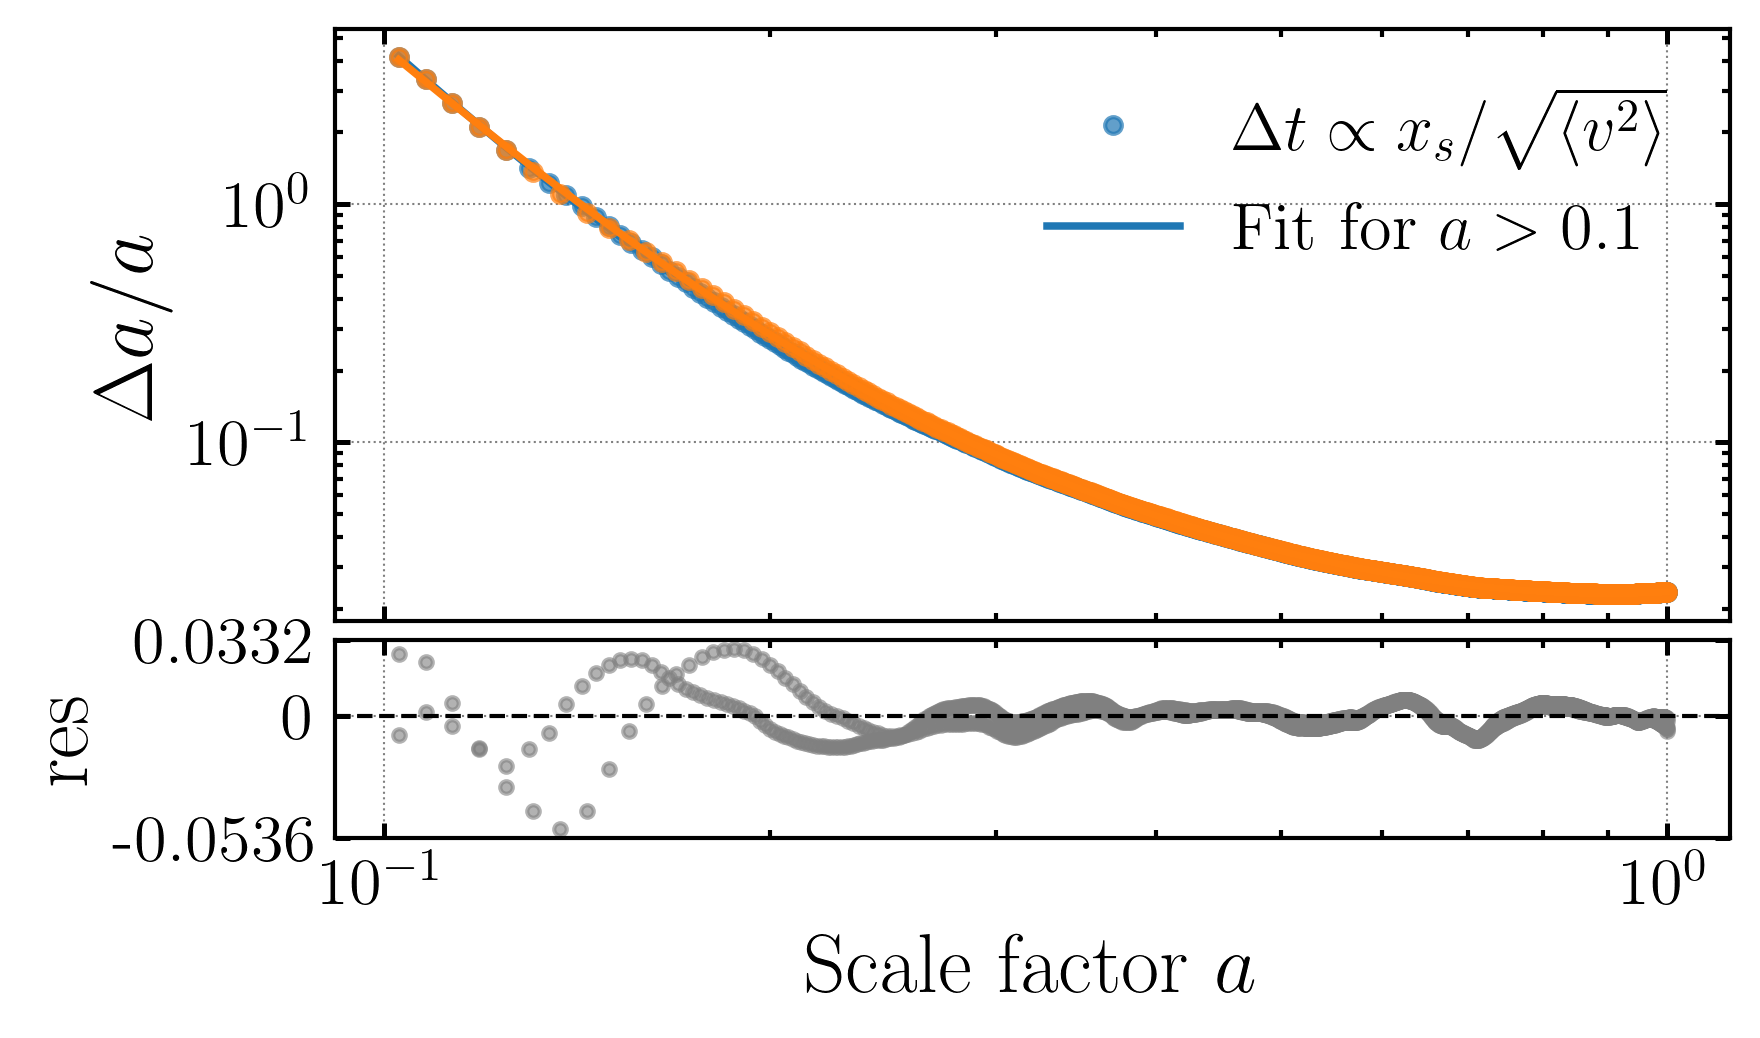

Simulation 0: Coefficients: [-3.74659557  0.39041298  1.90821078  1.10022755  0.5597775   0.09604354]
Coefficients saved to /home/hoellinger/wip3m/results/COLAr7/CV2_cola_Pf_L80_N160_Np160/coeffs_p3m_sim0.json
Simulation 1: Coefficients: [-3.74967124  0.32498523  1.68724927  0.84016171  0.45636105  0.08504407]
Coefficients saved to /home/hoellinger/wip3m/results/COLAr7/CV2_cola_Pf_L80_N160_Np160/coeffs_p3m_sim1.json


In [7]:
# For each sim_idx, fit the P3M time step distribution and plot the results
amin_fit=1e-1
amin_plot = 1e-1
# amin_plot = 5e-2
deg_fit = 5  # Degree of the polynomial fit for the P3M limiter

coeffs_list = []  # List to store the coefficients of each polynomial fit
for sim_idx in range(N_sim_fit):
    # Fit the P3M time step distribution
    a = aa[sim_idx]
    da_p3m = da_p3m_list[sim_idx]
    coeffs = fit_p3m(a, da_p3m, degree=deg_fit, amin=amin_fit)
    coeffs_list.append(coeffs)

fig = plt.figure(figsize=(6, 3.5))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

for sim_idx in range(N_sim_fit):
    a = aa[sim_idx]
    da_p3m = da_p3m_list[sim_idx]
    coeffs = coeffs_list[sim_idx]
    mask = a > amin_plot  # Filter out values below amin_plot
    a = a[mask]
    da_p3m = da_p3m[mask]
    ratio = da_p3m / a
    a_dense = np.logspace(np.log10(a.min()), np.log10(a.max()), 500)
    fit_vals = evaluate_polynomial_log(coeffs, a_dense)
    fit_interp = evaluate_polynomial_log(coeffs, a)
    residuals = np.log(ratio / fit_interp)

    # P3M limiter and fit
    if sim_idx == 0:
        ax1.plot(a, ratio, ".", alpha=0.7, color=f"C{sim_idx}", label=r"$\Delta t \propto x_s/\sqrt{\langle v^2 \rangle}$")
        ax1.plot(a_dense, fit_vals, "-", lw=1.8, color=f"C{sim_idx}", label=rf"Fit for $a > {amin_fit}$")
    else:
        ax1.plot(a, ratio, ".", alpha=0.7, color=f"C{sim_idx}")
        ax1.plot(a_dense, fit_vals, "-", lw=1.8, color=f"C{sim_idx}")
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    ax1.set_ylabel(r"$\Delta a/a$")
    ax1.legend(loc="upper right", frameon=False)
    ax1.tick_params(which="both", direction="in", top=True, right=True)
    ax1.grid(True, which="major", ls=":", lw=0.5)

    # Residuals
    ax2.plot(a, residuals, "o", color="grey", alpha=0.6, markersize=3)

ax2.axhline(0.0, color="black", lw=1, ls="--")
ax2.set_ylabel("res", labelpad=2)
ax2.set_xlabel(r"Scale factor $a$")
ax2.set_xscale("log")
ax2.set_yscale("symlog")

ax2.tick_params(which="both", direction="in", top=True, right=True)
ax2.grid(True, which="major", ls=":", lw=0.5)
ax1.tick_params(labelbottom=False)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.3g}"))
plt.show()

for sim_idx, coeffs in enumerate(coeffs_list):
    print(f"Simulation {sim_idx}: Coefficients: {coeffs}")
    coeffs_path = wd + f"coeffs_p3m_sim{sim_idx}.json"
    with open(coeffs_path, "w") as f:
        json.dump(coeffs.tolist(), f)
    print(f"Coefficients saved to {coeffs_path}")

In [8]:
for sim_idx in range(N_sim_fit):
    TSpath = TSpath_list[sim_idx]
    TS = P3MTimeStepping.read(TSpath)
    aiDrift = TS.aiDrift
    nsteps = TS.nsteps
    OutputTimestepsLog = OutputTimestepsLog_list[sim_idx]
    plot_custom_timestepping_diagnostics(
        log_path=OutputTimestepsLog,
        aiDrift=aiDrift,
        TimeStepDistribution=3,
        nsteps=nsteps,
        ymin=3e-3,
        ymax=0.5,
        fac_hubble=fac_hubble_list[sim_idx],
        fac_bend=fac_bend_list[sim_idx],
        da_max_early=da_early_list[sim_idx],
        da_max_late=DEFAULT_DA_MAX_LATE_CUSTOM,
        show=False,
    )
    fit_interp = evaluate_polynomial_log(coeffs_list[sim_idx], aa[sim_idx])
    plt.plot(aa[sim_idx], fit_interp, label=r"$\Delta t \propto x_s/\sqrt{\langle v^2 \rangle}$", color="black", alpha=0.7, zorder=10)
    plt.title(f"Simulation {sim_idx}")

[14:11:00|STATUS    ]|Read custom timestepping configuration in '/home/hoellinger/wip3m/results/COLAr7/CV2_cola_Pf_L80_N160_Np160/p3m1_rscale0_35_ts_p3m.h5'...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/hoellinger/wip3m/results/COLAr7/CV2_cola_Pf_L80_N160_Np160/p3m1_rscale0_35_ts_p3m.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)